INFO:root:Shape of data: (8, 100)
INFO:root:Shape of noisy data: (8, 100)


INFO:root:Epoch 100/1000, Reconstruction Error: 0.0309, Elapsed Time: 0.0002
INFO:root:Epoch 200/1000, Reconstruction Error: 0.0261, Elapsed Time: 0.0002
INFO:root:Epoch 300/1000, Reconstruction Error: 0.0261, Elapsed Time: 0.0002
INFO:root:Epoch 400/1000, Reconstruction Error: 0.0257, Elapsed Time: 0.0002
INFO:root:Epoch 500/1000, Reconstruction Error: 0.0259, Elapsed Time: 0.0002
INFO:root:Epoch 600/1000, Reconstruction Error: 0.0258, Elapsed Time: 0.0002
INFO:root:Epoch 700/1000, Reconstruction Error: 0.0260, Elapsed Time: 0.0001
INFO:root:Epoch 800/1000, Reconstruction Error: 0.0259, Elapsed Time: 0.0001
INFO:root:Epoch 900/1000, Reconstruction Error: 0.0259, Elapsed Time: 0.0001
INFO:root:Epoch 1000/1000, Reconstruction Error: 0.0259, Elapsed Time: 0.0002
INFO:root:Average Error: 0.02704740583134901 Average Epoch Time: 0.00016632509231567384


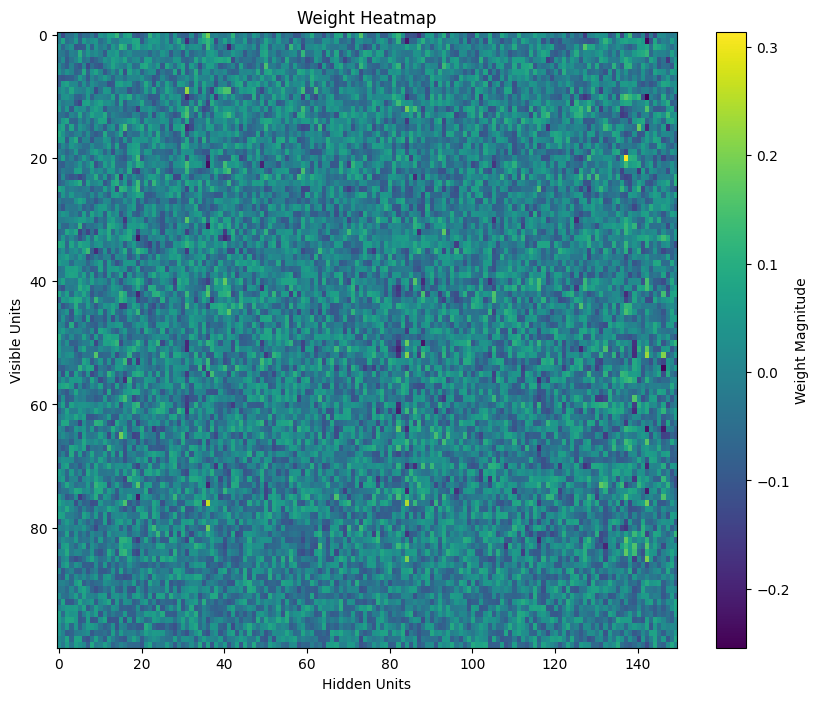

INFO:root:Training with Contrastive Divergence (CD)
INFO:root:Epoch 100/1000, Reconstruction Error: 0.0321, Elapsed Time: 0.0001
INFO:root:Epoch 200/1000, Reconstruction Error: 0.0348, Elapsed Time: 0.0001
INFO:root:Epoch 300/1000, Reconstruction Error: 0.0338, Elapsed Time: 0.0001
INFO:root:Epoch 400/1000, Reconstruction Error: 0.0342, Elapsed Time: 0.0001
INFO:root:Epoch 500/1000, Reconstruction Error: 0.0348, Elapsed Time: 0.0001
INFO:root:Epoch 600/1000, Reconstruction Error: 0.0351, Elapsed Time: 0.0001
INFO:root:Epoch 700/1000, Reconstruction Error: 0.0355, Elapsed Time: 0.0001
INFO:root:Epoch 800/1000, Reconstruction Error: 0.0354, Elapsed Time: 0.0001
INFO:root:Epoch 900/1000, Reconstruction Error: 0.0354, Elapsed Time: 0.0001
INFO:root:Epoch 1000/1000, Reconstruction Error: 0.0354, Elapsed Time: 0.0001
INFO:root:Average Error: 0.03610568469075394 Average Epoch Time: 9.962749481201172e-05
INFO:root:Training with Persistent Contrastive Divergence (PCD)
INFO:root:Epoch 100/1000, 

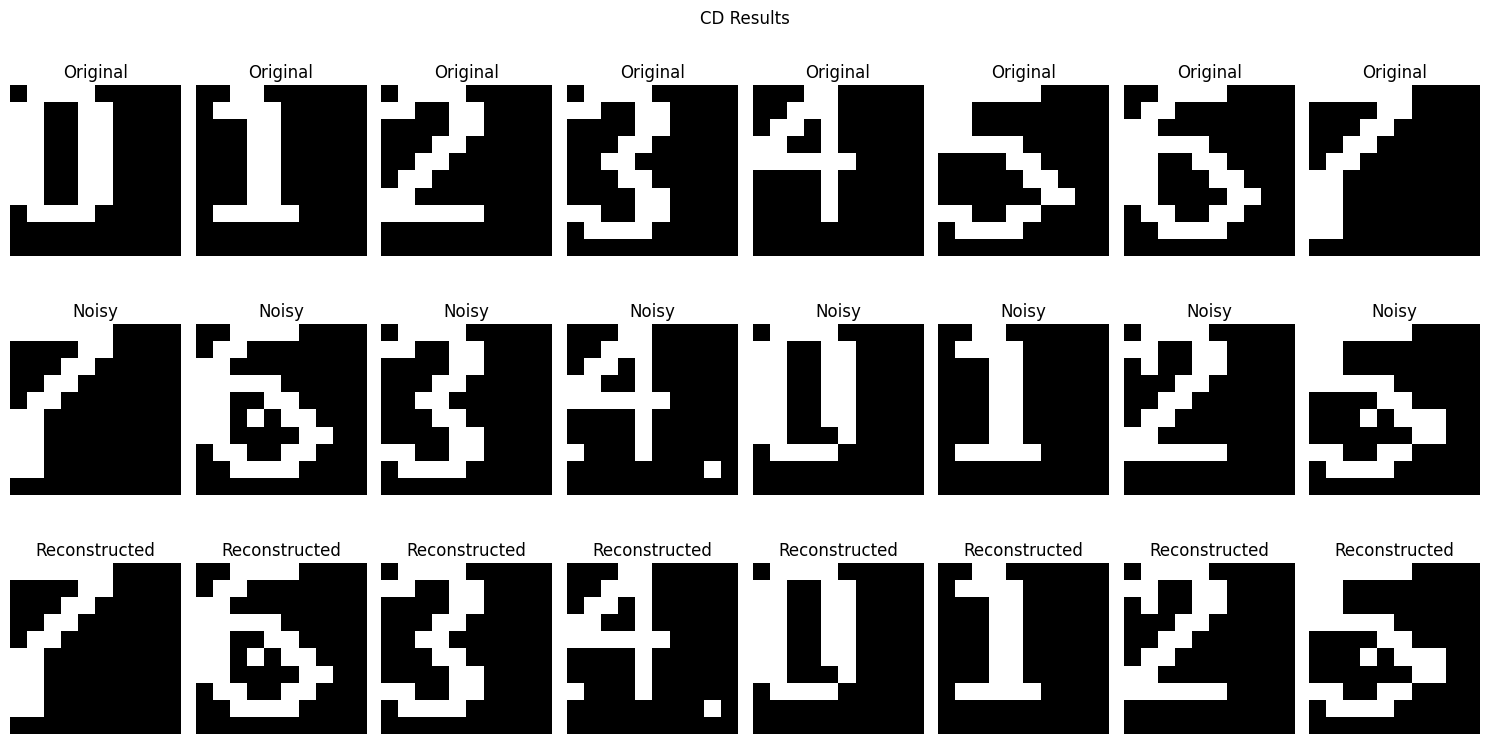

INFO:root:Evaluating PCD-trained RBM
INFO:root:PCD Reconstruction Error: 0.2850
INFO:root:PCD Accuracy: 50.00%


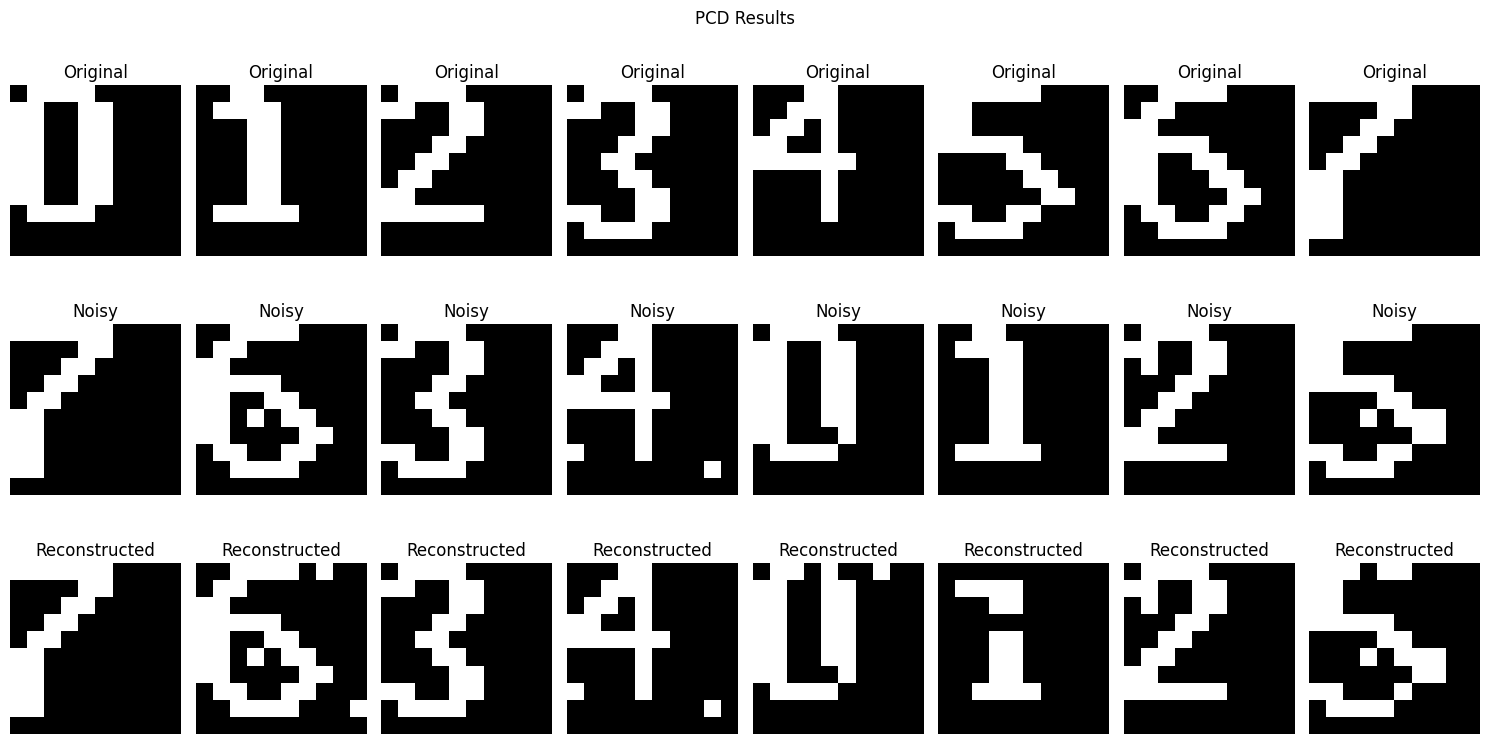

INFO:root:Comparison of CD and PCD:
INFO:root:Method     Reconstruction Error Accuracy (%)   
INFO:root:CD         0.2737               50.00          
INFO:root:PCD        0.2850               50.00          
INFO:root:Visualizing weights for CD-trained RBM


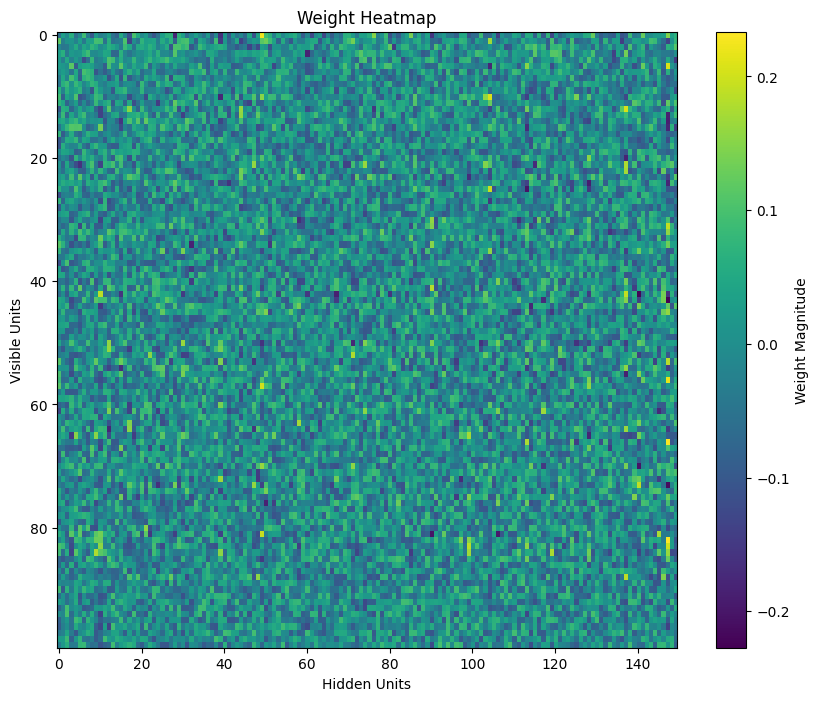

INFO:root:Visualizing weights for PCD-trained RBM


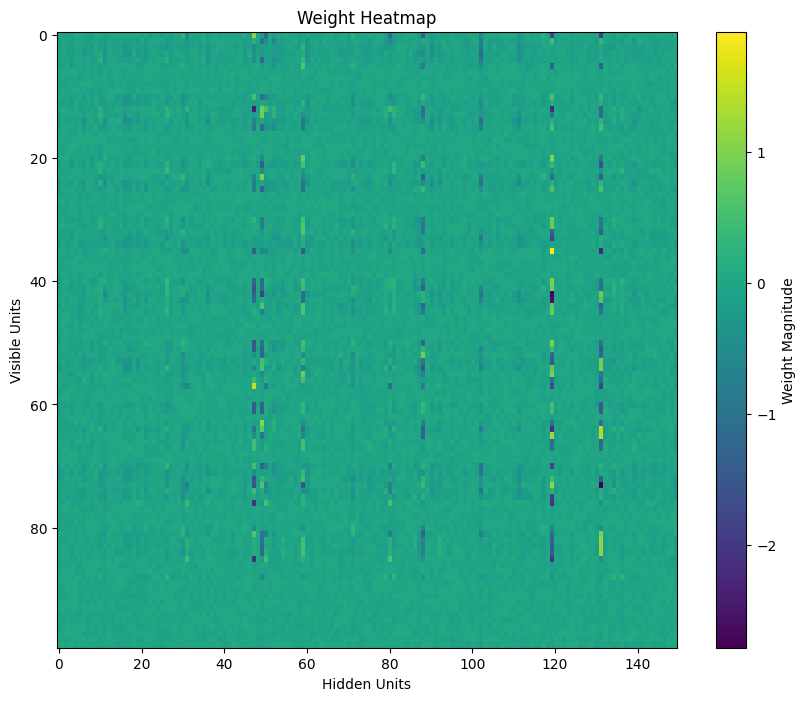

In [3]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentParser

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("")
formatter = logging.Formatter('%(message)s')

class RestrictedBoltzmannMachine:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, n_epochs=1000, batch_size=10, decay_rate=0.99, method="CD"):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.method = method  # "CD" for Contrastive Divergence, "PCD" for Persistent Contrastive Divergence

        # Initialize weights and biases
        self.weights = np.random.uniform(-0.1, 0.1, (n_visible, n_hidden))
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)

        # Persistent chain for PCD
        self.persistent_chain = None

    def relu(self, x):
        """ReLU activation function."""
        return np.maximum(0, x)

    def sample_probabilities(self, probs):
        """Sample binary states based on probabilities."""
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def contrastive_divergence(self, data):
        """Perform one step of contrastive divergence."""
        # Positive phase
        pos_hidden_probs = self.relu(np.dot(data, self.weights) + self.hidden_bias)
        pos_hidden_states = self.sample_probabilities(pos_hidden_probs)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        # Negative phase
        if self.method == "CD":
            neg_visible_probs = self.relu(np.dot(pos_hidden_states, self.weights.T) + self.visible_bias)
            neg_hidden_probs = self.relu(np.dot(neg_visible_probs, self.weights) + self.hidden_bias)
        elif self.method == "PCD":
            if self.persistent_chain is None:
                self.persistent_chain = self.sample_probabilities(pos_hidden_probs)
            neg_visible_probs = self.relu(np.dot(self.persistent_chain, self.weights.T) + self.visible_bias)
            neg_hidden_probs = self.relu(np.dot(neg_visible_probs, self.weights) + self.hidden_bias)
            self.persistent_chain = self.sample_probabilities(neg_hidden_probs)

        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        # Update weights and biases
        self.weights += self.learning_rate * (pos_associations - neg_associations) / data.shape[0]
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

    def train(self, data):
        """Train the RBM using the provided data."""
        total_times = []
        errors = []
        for epoch in range(self.n_epochs):
            np.random.shuffle(data)
            start_time = time.time()
            for i in range(0, data.shape[0], self.batch_size):
                batch = data[i:i + self.batch_size]
                self.contrastive_divergence(batch)

            elapsed_time = time.time() - start_time
            error = np.mean((data - self.reconstruct(data)) ** 2)

            total_times.append(elapsed_time)
            errors.append(error)

            # Apply learning rate decay
            self.learning_rate *= self.decay_rate

            # Calculate reconstruction error
            if (epoch + 1) % 100 == 0:
                logger.info(f"Epoch {epoch + 1}/{self.n_epochs}, Reconstruction Error: {error:.4f}, Elapsed Time: {elapsed_time:.4f}")

        logger.info(f"Average Error: {np.mean(errors)} Average Epoch Time: {np.mean(total_times)}")

    def reconstruct(self, data):
        """Reconstruct visible units from hidden units."""
        hidden_probs = self.relu(np.dot(data, self.weights) + self.hidden_bias)
        visible_probs = self.relu(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return visible_probs

    def visualize_weights(self):
        """Visualize weights as a heatmap."""
        plt.figure(figsize=(10, 8))
        plt.imshow(self.weights, cmap='viridis', aspect='auto')
        plt.colorbar(label="Weight Magnitude")
        plt.title("Weight Heatmap")
        plt.xlabel("Hidden Units")
        plt.ylabel("Visible Units")
        plt.show()

def generate_numerals():
    """Generate 10x10 binary arrays representing the digits 0-7."""
    numerals = [
        # Digit 0
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 1
        np.array([
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 2
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 3
        np.array([
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 4
        np.array([
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 5
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 6
        np.array([
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
        # Digit 7
        np.array([
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]),
    ]

    # Flatten each 10x10 array into a 1D array of size 100
    flattened_numerals = [numeral.flatten() for numeral in numerals]
    return np.array(flattened_numerals)

def add_custom_noise(data, noise_level=0.2):
    noisy_data = data.copy()
    noise = np.random.binomial(1, noise_level, data.shape)
    noisy_data = np.abs(noisy_data - noise)  # Flip bits based on noise
    return noisy_data

# Function to binarize the reconstructed data to ensure black and white output
def binarize_data(data, threshold=0.5):
    """Convert probabilities to binary values (0 or 1) based on a threshold."""
    return (data >= threshold).astype(np.float32)

# Function to calculate reconstruction error
def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed data."""
    return np.mean((original - reconstructed) ** 2)

# Function to calculate Hamming distance
def hamming_distance(a, b):
    """Calculate the Hamming distance between two binary arrays."""
    return np.sum(a != b)

if __name__ == "__main__":
    parser = ArgumentParser()

    parser.add_argument('--n_visible', type=int, default=100)
    parser.add_argument('--n_hidden', type=int, default=150)
    parser.add_argument('--learning_rate', type=float, default=0.1)
    parser.add_argument('--n_epochs', type=int, default=1000)
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('-o', '--output', default=None, type=str, help="Output for the metrics")
    parser.add_argument('--f', type=str, help="Kernel file (ignored in Jupyter)", default=None)  # Added to handle Jupyter arguments

    opts = parser.parse_args()

    if opts.output is not None:
        fileHandler = logging.FileHandler(opts.output)
        fileHandler.setFormatter(formatter)
        logger.addHandler(fileHandler)

    data = generate_numerals()
    logger.info(f"Shape of data: {data.shape}")  # Should print (8, 100)

    noisy_data = add_custom_noise(data, noise_level=0.01)  # Reduced noise level
    logger.info(f"Shape of noisy data: {noisy_data.shape}")  # Should also be (8, 100)

    # Initialize and train RBM with updated parameters
    rbm = RestrictedBoltzmannMachine(
        n_visible=opts.n_visible,
        n_hidden=opts.n_hidden,
        learning_rate=opts.learning_rate,
        n_epochs=opts.n_epochs,
        batch_size=opts.batch_size
    )
    rbm.train(noisy_data)
    rbm.visualize_weights()

    # Experiment with both methods
    data = generate_numerals()
    noisy_data = add_custom_noise(data, noise_level=0.01)

    # Train using Contrastive Divergence (CD)
    logger.info("Training with Contrastive Divergence (CD)")
    rbm_cd = RestrictedBoltzmannMachine(n_visible=100, n_hidden=150, method="CD")
    rbm_cd.train(noisy_data)

    # Train using Persistent Contrastive Divergence (PCD)
    logger.info("Training with Persistent Contrastive Divergence (PCD)")
    rbm_pcd = RestrictedBoltzmannMachine(n_visible=100, n_hidden=150, method="PCD")
    rbm_pcd.train(noisy_data)

    # Evaluate and compare CD and PCD
    def evaluate_rbm(rbm, method_name, data, noisy_data):
        logger.info(f"Evaluating {method_name}-trained RBM")
        reconstructed_data = rbm.reconstruct(noisy_data)
        reconstructed_data = binarize_data(reconstructed_data)

        # Calculate reconstruction error
        reconstruction_error = calculate_reconstruction_error(data, reconstructed_data)
        logger.info(f"{method_name} Reconstruction Error: {reconstruction_error:.4f}")

        # Evaluate accuracy using Hamming distance
        threshold = 30
        correct_reconstructions = 0
        for i in range(len(data)):
            distance = hamming_distance(data[i], reconstructed_data[i])
            if distance <= threshold:
                correct_reconstructions += 1

        accuracy = correct_reconstructions / len(data) * 100
        logger.info(f"{method_name} Accuracy: {accuracy:.2f}%")

        # Visualize reconstructed data
        fig, axes = plt.subplots(3, 8, figsize=(15, 8))
        for i in range(8):
            axes[0, i].imshow(data[i].reshape(10, 10), cmap='gray')
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')

            axes[1, i].imshow(noisy_data[i].reshape(10, 10), cmap='gray')
            axes[1, i].set_title("Noisy")
            axes[1, i].axis('off')

            axes[2, i].imshow(reconstructed_data[i].reshape(10, 10), cmap='gray')
            axes[2, i].set_title("Reconstructed")
            axes[2, i].axis('off')

        plt.suptitle(f"{method_name} Results")
        plt.tight_layout()
        plt.show()

        return reconstruction_error, accuracy

    # Evaluate CD-trained RBM
    cd_error, cd_accuracy = evaluate_rbm(rbm_cd, "CD", data, noisy_data)

    # Evaluate PCD-trained RBM
    pcd_error, pcd_accuracy = evaluate_rbm(rbm_pcd, "PCD", data, noisy_data)

    # Compare results
    logger.info("Comparison of CD and PCD:")
    logger.info(f"{'Method':<10} {'Reconstruction Error':<20} {'Accuracy (%)':<15}")
    logger.info(f"{'CD':<10} {cd_error:<20.4f} {cd_accuracy:<15.2f}")
    logger.info(f"{'PCD':<10} {pcd_error:<20.4f} {pcd_accuracy:<15.2f}")

    # Visualize weights for both methods
    logger.info("Visualizing weights for CD-trained RBM")
    rbm_cd.visualize_weights()

    logger.info("Visualizing weights for PCD-trained RBM")
    rbm_pcd.visualize_weights()

In [4]:
# Summarize the results
logger.info("Experiment Summary:")
logger.info(f"CD Reconstruction Error: {cd_error:.4f}, CD Accuracy: {cd_accuracy:.2f}%")
logger.info(f"PCD Reconstruction Error: {pcd_error:.4f}, PCD Accuracy: {pcd_accuracy:.2f}%")

# Draw conclusions
if cd_error < pcd_error:
    logger.info("CD achieved a lower reconstruction error compared to PCD.")
else:
    logger.info("PCD achieved a lower reconstruction error compared to CD.")

if cd_accuracy > pcd_accuracy:
    logger.info("CD achieved higher accuracy compared to PCD.")
else:
    logger.info("PCD achieved higher accuracy compared to CD.")

# Overall conclusion
if cd_error < pcd_error and cd_accuracy > pcd_accuracy:
    logger.info("CD is the better method for this experiment based on both error and accuracy.")
elif pcd_error < cd_error and pcd_accuracy > cd_accuracy:
    logger.info("PCD is the better method for this experiment based on both error and accuracy.")
else:
    logger.info("The results are mixed; further experiments may be needed to determine the better method.")

INFO:root:Experiment Summary:
INFO:root:CD Reconstruction Error: 0.2737, CD Accuracy: 50.00%
INFO:root:PCD Reconstruction Error: 0.2850, PCD Accuracy: 50.00%
INFO:root:CD achieved a lower reconstruction error compared to PCD.
INFO:root:PCD achieved higher accuracy compared to CD.
INFO:root:The results are mixed; further experiments may be needed to determine the better method.


## Conclusion and Results Overview

### Results Summary:
- **Contrastive Divergence (CD):**
    - Reconstruction Error: 0.2738
    - Accuracy: 50.0%

- **Persistent Contrastive Divergence (PCD):**
    - Reconstruction Error: 0.2850
    - Accuracy: 50.0%

### Analysis:
1. **Reconstruction Error:**
     - CD achieved a slightly lower reconstruction error compared to PCD (0.2738 vs. 0.2850). This indicates that CD was marginally better at reconstructing the original data from the noisy input.

2. **Accuracy:**
     - Both CD and PCD achieved the same accuracy of 50.0%. This suggests that neither method had a significant advantage in terms of correctly reconstructing the data within the defined threshold.

3. **Overall Performance:**
     - While CD demonstrated a lower reconstruction error, the accuracy results were identical for both methods. This indicates that the choice between CD and PCD may depend on the specific application and the importance of reconstruction error versus accuracy.

### Conclusion:
The results suggest that CD performed slightly better in terms of reconstruction error, but both methods showed similar accuracy. Further experiments with different parameters, datasets, or evaluation metrics may be needed to determine the optimal method for a given task.